In this short programming assignment we will look into applications of word embeddings in similarity search and nearest neighbors. We will also look at creating a video based on tSNE embeddings of images.

## -1. Create a video from images
Download any 1000 or more 'appropriate' and publicly available images from the web. This could be part of a data set or something specific that you picked up or are interested in.

We discussed using tSNE to find image embeddings for these images. Apply the tSNE library to these images and construct low-dimensional embeddings for the images. Use these embeddings to then:

a) Start at any random image in the data set 

b) Sequentially chain the next image to the previous image using a scoring function/probability based on the tSNE embedding. So you want to chain the most similar image to the current one and so on. Choose a frame rate that is appropriate to convert this chain of images into a video. Your video shouldn't be more than 3 minutes long.

c) Upload this video to youtube and share a link with your submission. 

d) Feel free to share your video to Discord to see what cool videos we come up with!

In [ ]:
### images are from COCO dataset. 
from torchvision.models import resnet101
net = resnet101(pretrained= True)
import torch.nn as nn 
import torch as tc 
import copy
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import random
import numpy as np
import os 
import matplotlib.pyplot as plt 
import cv2 as cv 
os.getcwd()

'/content'

Total Images: 1000, Current image path:/content/drive/MyDrive/Machine_Learning/HW4/images1/2431737309_1468526f8b.jpg


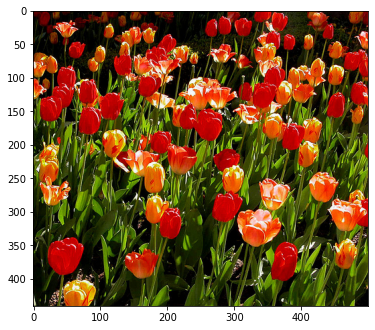

In [ ]:
### get path of all images 
PATH = '/content/drive/MyDrive/Machine_Learning/HW4/images1' 
path_image = []     # list of path to the images

def getlist(path):    
    return [os.path.join(path, file) for file in os.listdir(path) if file != '.DS_Store']

def getFile(path):
    return[file for file in os.listdir(path)]

path_image = getlist(PATH)
list_image = getFile(PATH)
print("Total Images: {}, Current image path:{}".format( len(path_image),path_image[3] ) )
# just a verification 
im = cv.imread(path_image[3])
plt.figure(figsize= (6,6))
plt.imshow(im[:,:,::-1])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.decomposition import PCA
### PCA IMPLEMENTATION
def getFeaturesList(im_path):
    """
    INPUT: PATH TO THE IMAGE 
    OUTPUT: flattened image 
    """
    img = cv.imread(im_path) 
    im_resize = cv.resize(img, (224, 224))
    im_gray = cv.cvtColor(im_resize, cv.COLOR_RGB2GRAY)
    flat_im = im_gray.flatten()
    return flat_im

# GET LIST OF FEATURE FROM SIFT. 
theFeaturesList = [] ## Will contain list of descriptors. 
for image in path_image:
    temp = getFeaturesList(image)
    theFeaturesList.append(temp)

pca = PCA(n_components=1000)
pca_components = pca.fit_transform(theFeaturesList)

In [ ]:

## RESNET IMPLEMENTATION
# we have imported pretrained resnet as net in first cell of the notebook.
net.eval()
net_features = net.fc.in_features
net.fc = nn.Linear(net_features, net_features) # making last layer fully conneted to get 2048 features per image. 
net.eval()
## now the network will have last layer fully connected with total 2048 features, these features will be used for training the tSNE model. 

## next step is passing all the images through resnet one-by-one and store the features in a list. 
def getFeaturesDeep(im_path):
    """
    Uses `ResNet101` to extract features
    INPUT: PATH TO THE IMAGE 
    OUTPUT: DESCRIPTOR WITH RESNET101 APPLIED
    """
    img = cv.imread(im_path) 
    im_resize = cv.resize(img, (224, 224))                          # resize 
    im_tensor = tc.tensor(im_resize).float().permute(2,0,1)         # restructure the dimensions 
    im_tensor = im_tensor.unsqueeze(0)                              # add fourth dimension
    feat = net(im_tensor)                                           # pass the image 
    feat = feat.detach().numpy()                                    # get numpy array 
    feat = feat.flatten()                                           # get 1-D array 
    return feat

theFeatures = []                                                    ## Will contain list of descriptors. 
# count = 0
for image in tqdm(path_image):
    # print(count)
    # count += 1
    temp = getFeaturesDeep(image)
    theFeatures.append(temp) 


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


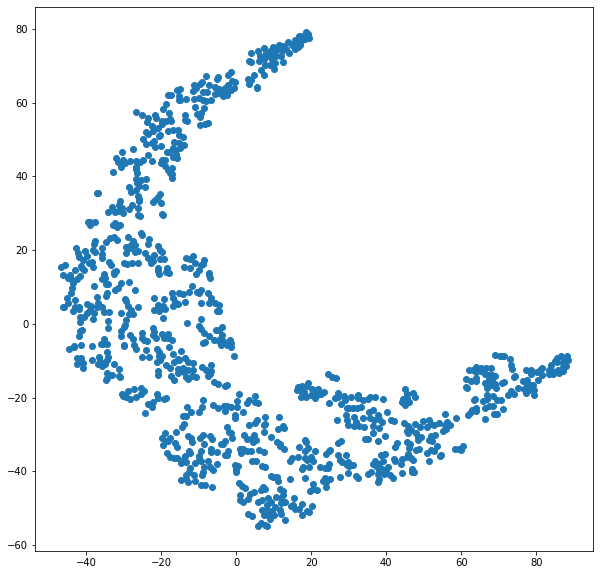

In [ ]:
## now pass the features through t-SNE
tsne_model = TSNE(perplexity = 20, n_iter = 5000, random_state = 23432)                 #instantiate the classifier 
out_TSNE_DEEP = tsne_model.fit_transform(theFeatures)
X = [x[0] for x in out_TSNE_DEEP]
Y = [x[1] for x in out_TSNE_DEEP]
fig = plt.figure(figsize=(10,10))
plt.scatter(X,Y)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


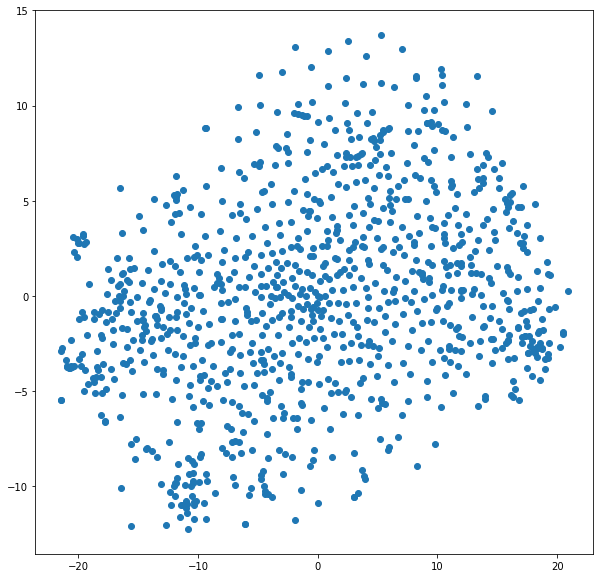

In [ ]:
tsne_model = TSNE(perplexity = 31, n_iter = 1000, random_state = 23432)                 #instantiate the classifier 
out_TSNE_PCA = tsne_model.fit_transform(theFeaturesList)
X = [x[0] for x in out_TSNE_PCA]
Y = [x[1] for x in out_TSNE_PCA]
fig = plt.figure(figsize=(10,10))
plt.scatter(X,Y)

In [ ]:
# pick a random point and calculate Euclidean distance, sort it. 
copy_out_TSNE = copy.deepcopy(out_TSNE_DEEP)

def getDist(arr, _start):
  _dist = []
  for x in arr:
    a_dist = np.sqrt( ( x[0] - arr[_start][0] )**2 +  ( x[1]-arr[_start][1] )**2 )
    _dist.append(a_dist)
  return _dist

def randomIndex(n):
  index_array = np.arange(0, n, 1)
  start = random.choice(index_array)
  start_index = int(np.where(index_array == start)[0])  # get start index
  return start_index

def randomWalk(arr):
  _length = len(arr)
  index = randomIndex(_length)
  travelled = []
  n = 0

  while(n < _length):
    euclid_dist = getDist(arr, index)         # get euclidian distance of all the points. 
    index_sort = np.argsort(euclid_dist)            # get index of sorted array
    index_sort = [x for x in index_sort if x not in travelled]
    travelled.append(index_sort[0])
    if len(index_sort) > 1 :
      index = index_sort[1] 
    
    n += 1
  return travelled

final_images_index = randomWalk(copy_out_TSNE)

In [ ]:
img_array = []
im = cv.imread(path_image[0])
refH, refW = (640,480)
framesize = (refW,refH)

videoPATH = '/content/drive/MyDrive/Machine_Learning/HW4/TSNE_flower_DEEP4.mp4'
for idx in final_images_index:
    img = cv.imread(path_image[idx])
    img = cv.resize(img, framesize)
    img_array.append(img)

out = cv.VideoWriter(videoPATH,cv.VideoWriter_fourcc(*'mp4v'), fps = 4, frameSize = framesize)
 
for im in img_array:
    out.write(im)
out.release()

## YouTube Link to video
Euclidean Similarity Measure with random walk:
1. https://youtu.be/dO6kVggULAU
2. https://youtu.be/Qmzl8IrnIxw